In [3]:
import sys
!{sys.executable} -m pip install pymongo
!{sys.executable} -m pip install pyyaml
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install moment
!{sys.executable} -m pip install statsmodels
import os
print(os.getcwd())
# Get Mongo database
from yaml import load
from pymongo import MongoClient
from getsecret import getsecret

client = MongoClient(getsecret("MONGODB_URI"))
db = client[getsecret("DB_NAME")]
# Get all synced accounts and their respective users.
import urllib.request as req
import json
accounts = json.loads(req.urlopen("http://localhost:5000/synced_emails").read().decode("utf-8"))

/Users/drewgregory/JupyterNotebooks/habitlab-data-analysis


In [4]:
# Get all sessions:
sessions = {}
for account in accounts:
    for user in account["android"]:
        for session in db[user + "_sessions"].find({"enabled": {"$exists": True}}):
            if user not in sessions:
                sessions[user] = {}
            domain = session["domain"]
            if domain not in sessions[user]:
                sessions[user][domain] = []
            sessions[user][domain].append(session)

In [34]:
# Now, check out if the sessions follow any distribution
session_durations = []
for user in sessions:
    for goal in sessions[user]:
        session_durations.extend([session["duration"] for session in sessions[user][goal] if session["duration"] < 3600])

(array([1.74581e+05, 3.17570e+04, 1.51920e+04, 1.15860e+04, 7.56200e+03,
        5.55300e+03, 5.30800e+03, 3.80500e+03, 2.99200e+03, 2.46600e+03,
        1.93700e+03, 1.77500e+03, 1.56700e+03, 2.08300e+03, 1.30600e+03,
        1.11700e+03, 9.79000e+02, 8.79000e+02, 7.91000e+02, 7.32000e+02,
        6.90000e+02, 5.65000e+02, 5.03000e+02, 4.90000e+02, 5.02000e+02,
        4.23000e+02, 3.99000e+02, 3.74000e+02, 4.09000e+02, 3.46000e+02,
        2.89000e+02, 3.32000e+02, 3.57000e+02, 3.24000e+02, 2.75000e+02,
        2.41000e+02, 2.36000e+02, 2.24000e+02, 2.17000e+02, 1.83000e+02,
        1.65000e+02, 1.82000e+02, 1.82000e+02, 1.76000e+02, 1.71000e+02,
        1.42000e+02, 1.41000e+02, 1.51000e+02, 1.34000e+02, 1.36000e+02,
        1.41000e+02, 1.28000e+02, 1.09000e+02, 1.02000e+02, 1.22000e+02,
        1.07000e+02, 1.02000e+02, 8.10000e+01, 1.19000e+02, 8.90000e+01,
        1.11000e+02, 9.00000e+01, 8.30000e+01, 7.60000e+01, 8.80000e+01,
        9.90000e+01, 9.40000e+01, 1.02000e+02, 7.70

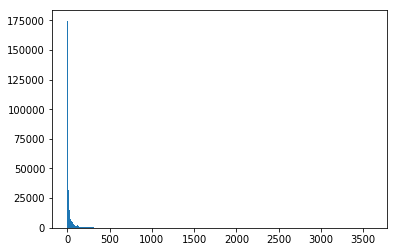

In [36]:
import matplotlib.pyplot as pyplot
pyplot.figure(1)
pyplot.hist(session_durations, bins= 400)

In [10]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        print(distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [11]:
print(str(best_fit_distribution(session_durations)))

('wald', (-1435368.1650060418, 4743374.936502483))


In [17]:
# WALD PARAMS: (-1435368.1650060418, 4743374.936502483)
from scipy.stats import wald, kstest
params = wald.fit(session_durations)
kstest(session_durations, 'wald', params)

KstestResult(statistic=0.8233338587441226, pvalue=0.0)

In [38]:
from statistics import mean
import moment
# what about total time per app per user per day??
sessions_per_day = []
for user in sessions:
    for goal in sessions[user]:
        prev_day = ""
        app_time_day = 0
        for session in sessions[user][goal]:
            day = moment.unix(session["timestamp"]).format("YYYY-MM-DD")
            app_time_day += session["duration"]
            if day != prev_day:
                if prev_day != "":
                    sessions_per_day.append(app_time_day)
                    app_time_day = 0
                prev_day = day

In [39]:
print(sessions_per_day)
print(str(best_fit_distribution(sessions_per_day)))

[73, 1341, 284, 8285, 172, 80, 4226, 6189, 10005, 2548, 52, 24, 93, 5, 23, 1375, 1554, 1682, 62, 21, 65, 912, 27, 280, 72, 22, 457, 413, 1240, 612, 166, 151, 802, 712, 1, 19, 3401, 3615, 3090, 4416, 42, 12, 4360, 130, 652, 1, 577, 244, 216, 285, 359, 89, 170, 52, 83, 212, 285, 52, 256, 56, 46, 104, 183, 27, 74, 469, 394, 105, 339, 52, 21, 913, 12, 67, 2738, 410, 136, 58, 37, 81, 466, 51, 6, 3, 45, 2, 8, 19, 8, 2322, 47, 188, 155, 312, 171, 414, 1851, 490, 1004, 88, 642, 346, 2583, 129, 1259, 28647, 36414, 1, 57342, 28, 214, 197, 304, 81, 4, 558, 390, 50, 190, 12, 17, 323, 546, 106, 16, 2544, 46, 0, 65, 16, 6, 275, 55, 548, 261, 906, 64, 29, 140, 117, 776, 425, 459, 320, 428, 77, 22, 30, 17, 28, 85, 80, 137, 3, 0, 21, 375, 72, 574, 56, 98, 9, 26, 20, 288, 46, 3, 135, 50, 43, 90, 253, 199, 7, 27, 41, 51, 52, 17, 90, 64, 17, 77, 182, 3, 242, 421, 12, 339, 245, 91, 260, 31, 203, 39, 149, 234, 143, 225, 219, 140, 151, 104, 1, 140, 40, 709, 63, 396, 1, 234, 81, 178, 78, 44, 18, 10, 300, 174,

('exponnorm', (2139.5591586080654, -0.983121041949687, 0.4730654280867641))


In [41]:
kstest(sessions_per_day, 'exponnorm', (2139.5591586080654, -0.983121041949687, 0.4730654280867641))

KstestResult(statistic=0.3885666364468505, pvalue=0.0)

KstestResult(statistic=0.37184025155608813, pvalue=0.0)

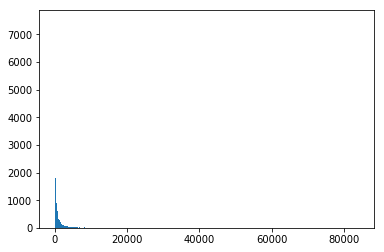

In [48]:
sessions_per_day = [s for s in sessions_per_day if s<20000 and s > 5]
from scipy.stats import exponnorm
params = exponnorm.fit(sessions_per_day)
pyplot.figure(2)
pyplot.hist(sessions_per_day, bins=400)
kstest(sessions_per_day, 'exponnorm', params)